# Training a Raspberry Pi to Detect Traffic Signs and People in Real Time

This is tutorial is based on Chengwei's excellent Tutorial and Colab Notebook on ["How to train an object detection model easy for free"](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/).   My twist on his tutorial is that I need to run my model on a Raspberry Pi with live video feed.  As the Raspberry Pi is fairly limited on CPU power and can only run object detection at 1-2 FPS (frames/sec), I have purchased the newly release $75 Google's [EdgeTPU USB Accelarator](https://coral.withgoogle.com/products/accelerator), which can detect objects at 12 FPS, which is sufficient for real time work.  After doing the transfer learning from one of the object detection models using our own images, last few steps of the colab deals with how to convert a trained model to a model file that can be consumed by an Edge TPU, namely, the final `mymodel_quantized_edgetpu.tflite` file.  


![](https://cdn-images-1.medium.com/max/1000/1*_jABdMfUVcyPdi5b3zlfVg.jpeg)



# Section 1: Mount Google drive
Mount my Google Drive and save modeling output files (`.ckpt`)  there, so that it won't be wiped out when colab Virtual Machine restarts.  It has an idle timeout of 90 min, and maximum daily usage of 12 hours.

Google will ask for an authenticate code when you run the following code, just follow the link in the output and allow access.   You can put the `model_dir` anywhere in your google drive.

In [1]:
!pip install numpy==1.17.4

     |████████████████████████████████| 20.0MB 1.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [ ]:
!pip show numpy

Name: numpy
Version: 1.18.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: yellowbrick, xgboost, xarray, wordcloud, umap-learn, torchvision, torchtext, torch, tifffile, thinc, Theano, tensorflow, tensorflow-probability, tensorflow-hub, tensorflow-datasets, tensorboard, tables, statsmodels, spacy, sklearn-pandas, seaborn, scs, scipy, scikit-learn, resampy, PyWavelets, python-louvain, pystan, pysndfile, pymc3, pyemd, pyarrow, plotnine, patsy, pandas, osqp, opt-einsum, opencv-python, opencv-contrib-python, numexpr, numba, np-utils, nibabel, moviepy, mlxtend, mizani, missingno, matplotlib, matplotlib-venn, lucid, lightgbm, librosa, knnimpute, Keras, Keras-Preprocessing, Keras-Applications, kapre, jpeg4py, jaxlib, jax, imgaug, imbalanced-learn, imageio, hyperopt, h5py, gym, gensim, folium, fix-

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:

from google.colab import drive
drive.mount('/content/drive')
model_dir = '/content/drive/My Drive/Traffic_Sign_Detection_Own_Data'
#!rm -rf '{model_dir}'
#os.makedirs(model_dir, exist_ok=True)
!ls -ltra '{model_dir}'/..

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
total 4
drwx------ 2 root root 4096 Jul  2 10:43 Traffic_Sign_Detection_Own_Data


# Section 2: Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [3]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/WalterYeYint/Traffic_Sign_Training_Own_Data'


# Number of training steps.
num_steps = 1000  # 200000
#num_steps = 100  # 200000

# Number of evaluation steps.
num_eval_steps = 50


# model configs are from Model Zoo github: 
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models
MODELS_CONFIG = {
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz
    'ssd_mobilenet_v1_quantized': {
        'model_name': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18',
        'pipeline_file': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync.config',
        'batch_size': 12
    },    
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 31
    },
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03.tar.gz
    'ssd_mobilenet_v2_quantized': {
        'model_name': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03',
        'pipeline_file': 'ssd_mobilenet_v2_quantized_300x300_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 12
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
# Note: for Edge TPU, you have to:
# 1) start with a pretrained model from model zoo, such as above 4
# 2) Must be a quantized model, which reduces the model size significantly
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

# Section 3: Set up Training Environment

## Clone the `DeepPiCar` repository or your fork.

In [4]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}

print('Pull it so that we have the latest code/data')
!git pull

/content
Cloning into 'Traffic_Sign_Training_Own_Data'...
remote: Enumerating objects: 407, done.
remote: Counting objects: 100% (407/407), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 407 (delta 171), reused 391 (delta 158), pack-reused 0
Receiving objects: 100% (407/407), 44.83 MiB | 22.79 MiB/s, done.
Resolving deltas: 100% (171/171), done.
/content/Traffic_Sign_Training_Own_Data
Pull it so that we have the latest code/data
Already up to date.


## Install required packages

In [5]:
!pip install tf_slim

     |████████████████████████████████| 358kB 3.5MB/s 


In [6]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'



/content
Selecting previously unselected package python-bs4.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

In [ ]:
!python object_detection/builders/model_builder_test.py

## Prepare `tfrecord` files

Use the following scripts to generate the `tfrecord` files.

```

In [7]:
%cd {repo_dir_path}/models/object_detection

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python code/xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
!python code/xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
!python code/generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
!python code/generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt

/content/Traffic_Sign_Training_Own_Data/models/object_detection
Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`
Successfully converted xml to csv.


W0702 10:49:33.318651 140259566638976 module_wrapper.py:139] From code/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0702 10:49:33.381831 140259566638976 module_wrapper.py:139] From code/generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/Traffic_Sign_Training_Own_Data/models/object_detection/data/annotations/train.record


W0702 10:49:39.715189 139782939912064 module_wrapper.py:139] From code/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0702 10:49:39.730588 139782939912064 module_wrapper.py:139] From code/generate_tfrecord.py:53: The name tf.gfile.GFile is depreca

In [8]:
test_record_fname = repo_dir_path + '/models/object_detection/data/annotations/test.record'
train_record_fname = repo_dir_path + '/models/object_detection/data/annotations/train.record'
label_map_pbtxt_fname = repo_dir_path + '/models/object_detection/data/annotations/label_map.pbtxt'

In [9]:
!cat data/annotations/test_labels.csv

filename,width,height,class,xmin,ymin,xmax,ymax
IMG_20200624_175735.jpg,640,480,Speed Limit 25,73,169,200,309
IMG_20200624_175735.jpg,640,480,Straight Or Left Sign,243,181,315,249
IMG_20200624_175735.jpg,640,480,Stop Sign,368,184,420,234
IMG_20200624_175735.jpg,640,480,Speed Limit 35,446,183,513,261
IMG_20200624_223954.jpg,640,480,Straight Or Right Sign,27,161,113,236
IMG_20200624_223954.jpg,640,480,Green Traffic Light,144,159,192,251
IMG_20200624_223954.jpg,640,480,Speed Limit 50,241,156,304,231
IMG_20200624_223954.jpg,640,480,Speed Limit 35,337,155,388,223
IMG_20200624_223954.jpg,640,480,Speed Limit 25,406,153,457,219
IMG_20200624_223954.jpg,640,480,Red Traffic Light,512,156,546,235
IMG_20200624_223954.jpg,640,480,Straight Or Left Sign,585,153,630,205
IMG_20200626_230024.jpg,640,480,Stop Sign,82,156,179,252
IMG_20200626_230024.jpg,640,480,Green Traffic Light,221,166,284,303
IMG_20200626_230024.jpg,640,480,Speed Limit 35,342,164,441,282
IMG_20200626_230024.jpg,640,480,Red Traffic Ligh

## Download base model

In [10]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [11]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 63 root   root  4.0K Jul  2 10:50 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [12]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

# Section 4: Transfer Learning Training

## Configuring a Training Pipeline

In [13]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [14]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [15]:
import re

# training pipeline file defines:
# - pretrain model path
# - the train/test sets
# - ID to Label mapping and number of classes
# - training batch size
# - epochs to trains
# - learning rate
# - etc

# note we just need to use a sample one, and make edits to it.

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint: downloaded pre-trained model checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test, we created earlier with our training/test sets
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path: ID to label file
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps (Number of epochs to train)
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [16]:
!cat {label_map_pbtxt_fname}

item {
    id: 1
    name: 'Green Traffic Light'
}

item {
    id: 2
    name: 'Red Traffic Light'
}

item {
    id: 3
    name: 'Speed Limit 25'
}

item {
    id: 4
    name: 'Speed Limit 35'
}

item {
    id: 5
    name: 'Speed Limit 50'
}

item {
    id: 6
    name: 'Stop Sign'
}

item {
    id: 7
    name: 'Straight Or Left Sign'
}

item {
    id: 8
    name: 'Straight Or Right Sign'
}

In [17]:
# look for num_classes: 6, since we have 5 different road signs and 1 person type (total of 6 types) 
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 8
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

## Run Tensorboard(Optional)

In [18]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-07-02 10:51:02--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.223.118.45, 18.213.76.145, 52.207.47.153, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.223.118.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  37.3MB/s    in 0.4s    

2020-07-02 10:51:03 (37.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [19]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir "{}" --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [20]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [21]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://8669281ac28a.ngrok.io


## Train the model

Now all inputs are set up, just train the model.   This process may take a few hours.   Since we are saving the model training results (model.ckpt-* files) in our google drive (a persistent storage that will survice the restart of our colab VM instance), we can safely leave and return a few hours later. 

In [ ]:
#################### SEND ALERT EMAIL AT FINISH WITH GMAIL #####################
# To send email from Python from your google account, MUST 
# 1) Enable less secure app
# https://myaccount.google.com/lesssecureapps
# 2) Disable Unlock Capcha
# https://accounts.google.com/b/0/DisplayUnlockCaptcha

import smtplib

def SendEmail(msg):
    with open('/content/gdrive/My Drive/Colab Notebooks/pw.txt') as file:
        data = file.readlines()
        
    gmail_user = 'david.tian@gmail.com'  
    gmail_password = data[0]


    sent_from = gmail_user  
    to = ['dctian@hotmail.com']  
    subject = msg  
    body = '%s\n\n- David' % msg

    email_text = \
"""From: %s
To: %s
Subject: %s

%s
""" % (sent_from, ", ".join(to), subject, body)

    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.ehlo()
    server.starttls()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, email_text)
    server.quit()

    print(f'Email: \n{email_text}')
    

In [22]:
num_steps = 2200
# SendEmail("Colab train started")
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir='{model_dir}' \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}
# SendEmail("Colab train finished")

W0702 10:51:25.741390 139658651641728 model_lib.py:717] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 2200
I0702 10:51:25.741623 139658651641728 config_util.py:552] Maybe overwriting train_steps: 2200
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0702 10:51:25.741756 139658651641728 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0702 10:51:25.741872 139658651641728 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0702 10:51:25.742023 139658651641728 config_util.py:552] Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
I0702 10:51:25.742141 139658651641728 config_util.py:552] Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
I0702 10:51:25.742255 139658651641728 config_util.py:5

In [23]:
!ls -ltra '{model_dir}'

total 482709
-rw------- 1 root root  3572006 Jun 29 16:43 'Copy of tensorflow_traffic_sign_detection.ipynb'
-rw------- 1 root root 20269332 Jul  2 10:52  graph.pbtxt
drwx------ 2 root root     4096 Jul  2 11:02  eval_0
-rw------- 1 root root    41915 Jul  2 17:53  model.ckpt-2018.index
-rw------- 1 root root 75758040 Jul  2 17:53  model.ckpt-2018.data-00000-of-00001
-rw------- 1 root root  9582415 Jul  2 17:53  model.ckpt-2018.meta
-rw------- 1 root root    41915 Jul  2 18:03  model.ckpt-2066.index
-rw------- 1 root root 75758040 Jul  2 18:03  model.ckpt-2066.data-00000-of-00001
-rw------- 1 root root  9582415 Jul  2 18:03  model.ckpt-2066.meta
-rw------- 1 root root    41915 Jul  2 18:13  model.ckpt-2114.index
-rw------- 1 root root 75758040 Jul  2 18:13  model.ckpt-2114.data-00000-of-00001
-rw------- 1 root root  9582415 Jul  2 18:13  model.ckpt-2114.meta
-rw------- 1 root root    41915 Jul  2 18:23  model.ckpt-2162.index
-rw------- 1 root root 75758040 Jul  2 18:23  model.ckpt-2162.

# Section 5: Save and Convert Model Output

## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [24]:
import os
import re
import numpy as np

output_directory = '%s/fine_tuned_model' % model_dir
os.makedirs(output_directory, exist_ok=True)

In [25]:
lst = os.listdir(model_dir)
# find the last model checkpoint file, i.e. model.ckpt-1000.meta
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)


/content/drive/My Drive/Traffic_Sign_Detection_Own_Data/model.ckpt-2200


In [26]:
!echo creates the frozen inference graph in fine_tune_model
# there is an "Incomplete shape" message.  but we can safely ignore that. 
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory='{output_directory}' \
    --trained_checkpoint_prefix='{last_model_path}'

creates the frozen inference graph in fine_tune_model
Instructions for updating:
Please use `layer.__call__` method instead.
W0702 18:33:04.999295 140573712729984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0702 18:33:07.221931 140573712729984 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0702 18:33:07.262980 140573712729984 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0702 18:33:07.406836 140573712729984 convolutional_box_predictor.py:156] depth of additional conv before box pred

In [27]:
# !ls {output_directory}
print(output_directory)

/content/drive/My Drive/Traffic_Sign_Detection_Own_Data/fine_tuned_model


## Download the model `.pb` file

In [28]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [ ]:
!ls -alh {pb_fname}

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/Traffic_Sign_Detection_Own_Data/fine_tuned_model/frozen_inference_graph.pb': No such file or directory


### Download the `label_map.pbtxt` file

In [29]:
from google.colab import files
files.download(label_map_pbtxt_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Run inference test
Test with images in repository `object_detection_demo/test` directory.

In [30]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "models/object_detection/data/images/test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200624_175735.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200626_230044.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200624_220938.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200624_185005.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200626_230024.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200624_223954.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200624_181343.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200626_230058.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200624_185311.jpg', '/content/Traffic_Sign_Trai

In [31]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

/content/models/research/object_detection


Running inferences on ['/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200626_230125.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200624_223954.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200624_181343.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200624_185005.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200624_220938.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200626_230024.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200626_230058.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200624_185311.jpg', '/content/Traffic_Sign_Training_Own_Data/models/object_detection/data/images/test/IMG_20200626_230044.jpg', '/con

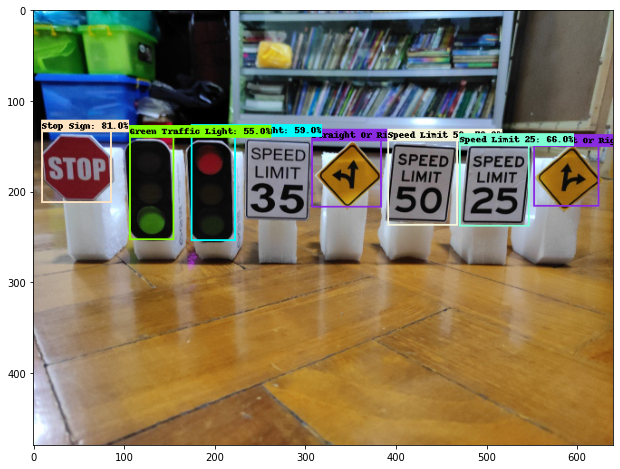

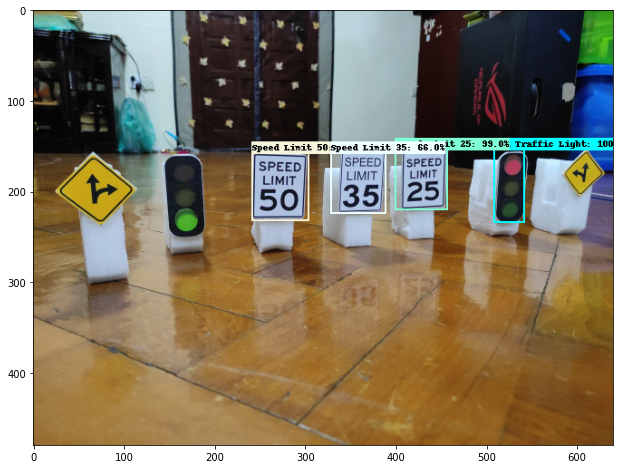

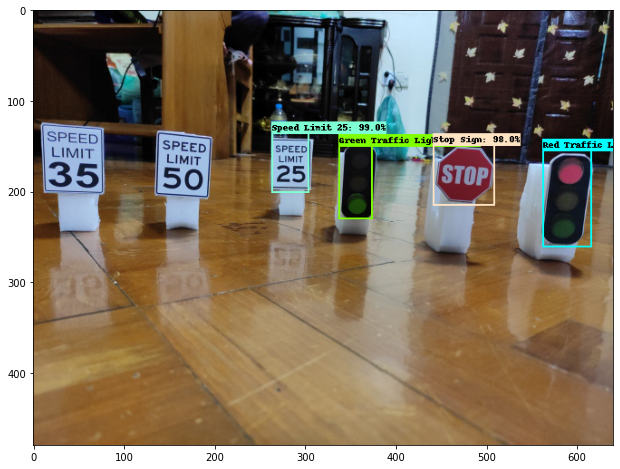

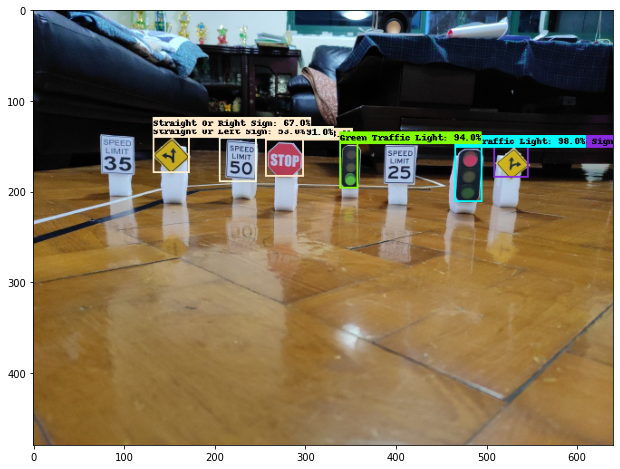

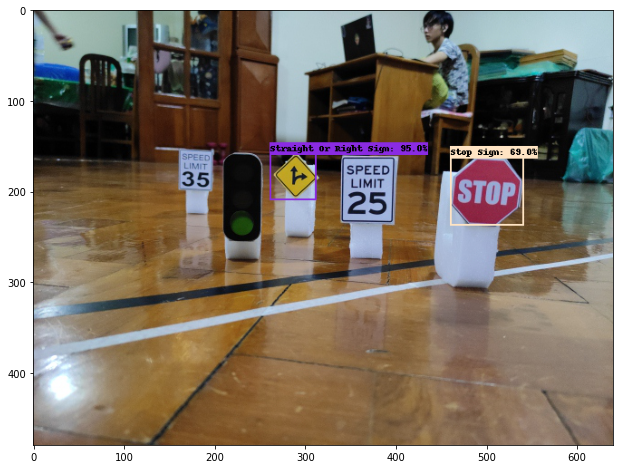

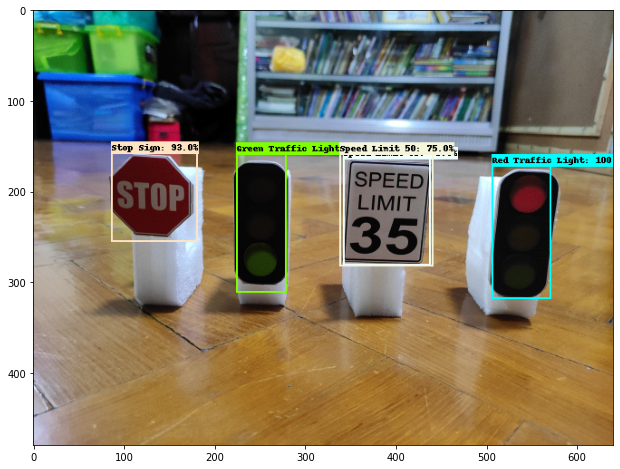

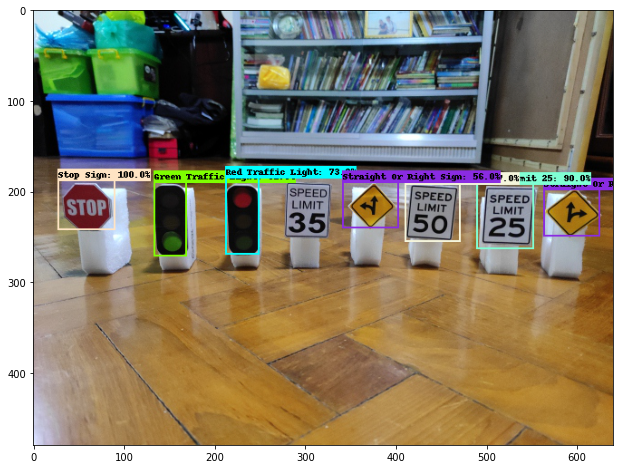

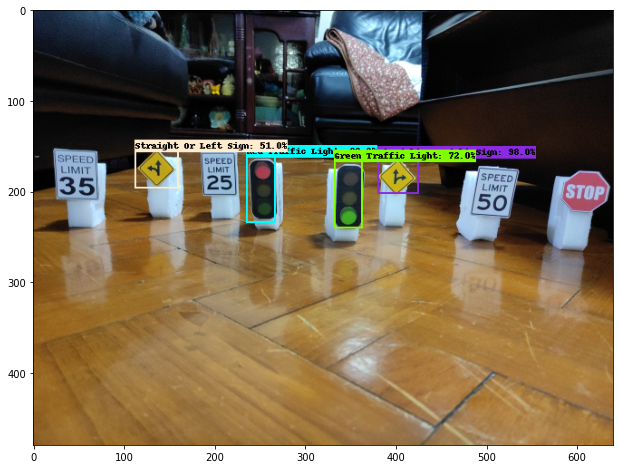

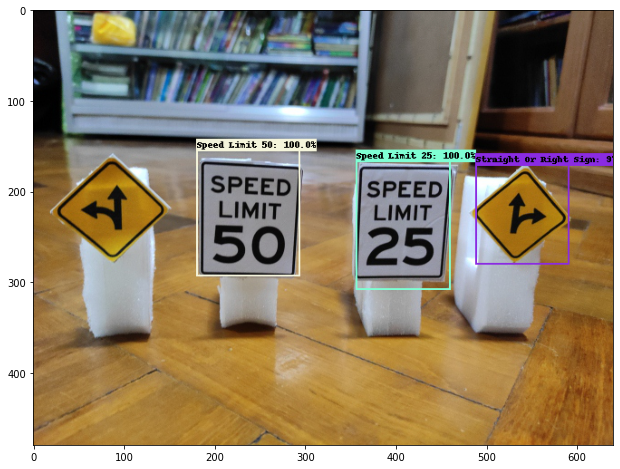

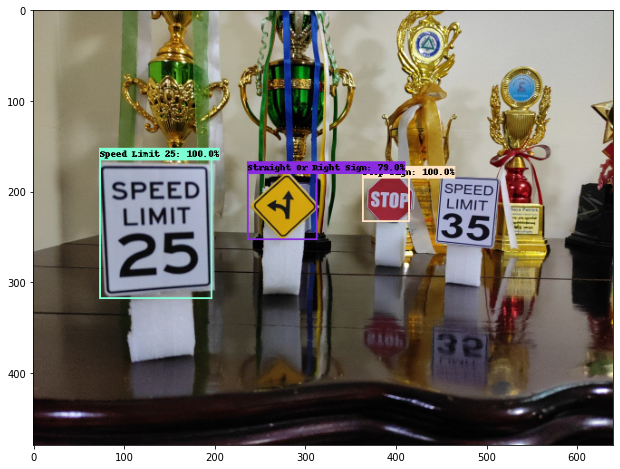

In [ ]:
# running inferences.  This should show images with bounding boxes
%matplotlib inline

print('Running inferences on %s' % TEST_IMAGE_PATHS)
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

# For Converting to TFLite

In [ ]:
# https://medium.com/tensorflow/training-and-serving-a-realtime-mobile-object-detector-in-30-minutes-with-cloud-tpus-b78971cf1193
# create the tensorflow lite graph
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path={pipeline_fname} \
    --trained_checkpoint_prefix='{last_model_path}' \
    --output_directory='{output_directory}' \
    --add_postprocessing_op=true

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
2019-04-16 23:43:30.284197: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-04-16 23:43:30.284471: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x21b0680 executing computations on platform Host. Devices:
2019-04-16 23:43:30.284508: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
Instructions for updating:
Use standard file APIs to check for files with this prefix.
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
2019-04-16 23:43:36.033642: I tensorflow/tools/graph_transforms/transform_graph.cc:317] Applying strip_unused_nodes


In [ ]:
!echo "CONVERTING frozen graph to quantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_quantized.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

CONVERTING frozen graph to quantized TF Lite file...
2019-04-16 23:43:43.502145: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-04-16 23:43:43.502467: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55f307f38dc0 executing computations on platform Host. Devices:
2019-04-16 23:43:43.502512: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


In [ ]:
!echo "CONVERTING frozen graph to unquantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_float.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops 


CONVERTING frozen graph to unquantized TF Lite file...
2019-04-16 23:43:50.953580: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-04-16 23:43:50.953813: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x557e01e1cdc0 executing computations on platform Host. Devices:
2019-04-16 23:43:50.953867: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


In [ ]:
print(output_directory)
!ls -ltra '{output_directory}'
#pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb") # this is main one
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")  # this is tflite graph
!cp '{label_map_pbtxt_fname}' '{output_directory}'

/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/fine_tuned_model
total 134782
drwx------ 3 root root     4096 Apr 16 20:19 saved_model
-rw------- 1 root root     4472 Apr 16 20:19 pipeline.config
-rw------- 1 root root      275 Apr 16 20:20 label_map.pbtxt
-rw------- 1 root root  2120806 Apr 16 23:43 model.ckpt.meta
-rw------- 1 root root    23543 Apr 16 23:43 model.ckpt.index
-rw------- 1 root root 18922628 Apr 16 23:43 model.ckpt.data-00000-of-00001
-rw------- 1 root root       77 Apr 16 23:43 checkpoint
-rw------- 1 root root 19755137 Apr 16 23:43 frozen_inference_graph.pb
-rw------- 1 root root 54189664 Apr 16 23:43 tflite_graph.pbtxt
-rw------- 1 root root 19406623 Apr 16 23:43 tflite_graph.pb
-rw------- 1 root root  4793504 Apr 16 23:43 road_signs_quantized.tflite
-rw------- 1 root root 18792240 Apr 16 23:43 road_signs_float.tflite


## Run inference test
Test with images in repository `object_detection/data/images/test` directory.

In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname
print(PATH_TO_CKPT)

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "models/object_detection/data/images/test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/fine_tuned_model/frozen_inference_graph.pb
['/content/DeepPiCar/models/object_detection/data/images/test/2019-04-16-100738.jpg', '/content/DeepPiCar/models/object_detection/data/images/test/2019-04-16-100317.jpg', '/content/DeepPiCar/models/object_detection/data/images/test/2019-04-16-101240.jpg', '/content/DeepPiCar/models/object_detection/data/images/test/2019-04-16-101426.jpg', '/content/DeepPiCar/models/object_detection/data/images/test/2019-04-16-095558.jpg']


In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict



/content/models/research/object_detection


Running inferences on ['/content/DeepPiCar/models/object_detection/data/images/test/2019-04-16-100738.jpg', '/content/DeepPiCar/models/object_detection/data/images/test/2019-04-16-100317.jpg', '/content/DeepPiCar/models/object_detection/data/images/test/2019-04-16-101240.jpg', '/content/DeepPiCar/models/object_detection/data/images/test/2019-04-16-101426.jpg', '/content/DeepPiCar/models/object_detection/data/images/test/2019-04-16-095558.jpg']


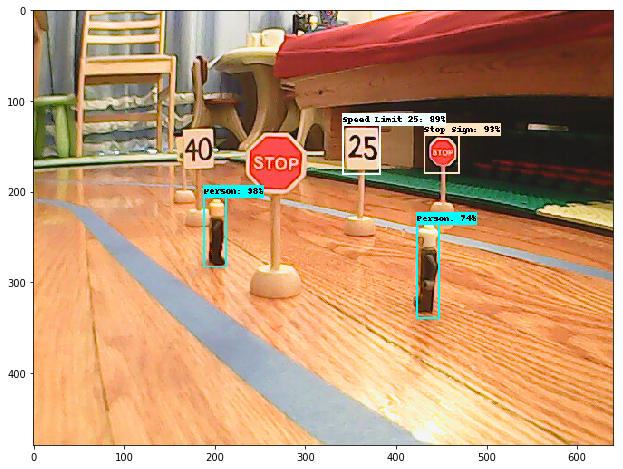

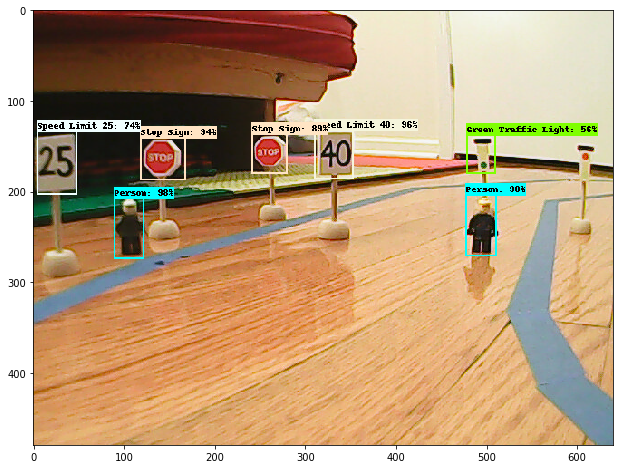

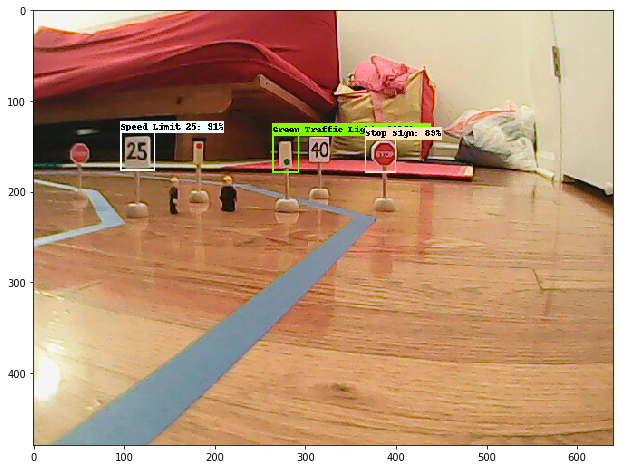

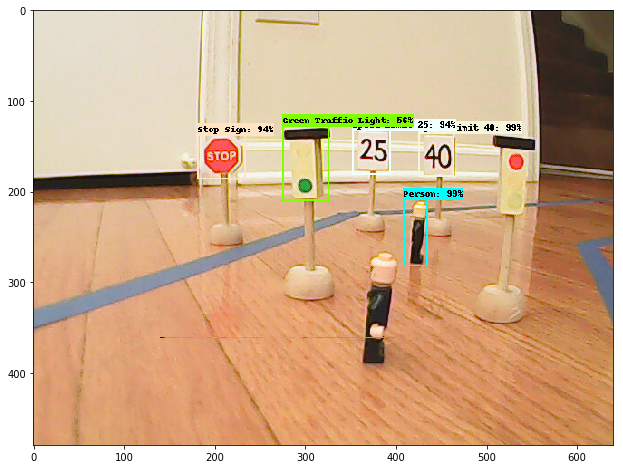

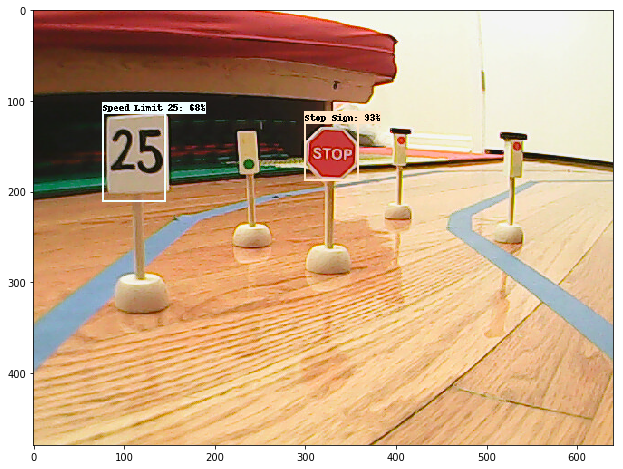

In [ ]:
# running inferences.  This should show images with bounding boxes
%matplotlib inline

print('Running inferences on %s' % TEST_IMAGE_PATHS)
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

## Convert to Edge TPU's tflite Format  
The only known way, at time of writing (April 2019), is to download the below quantized tflite file from above, and use [Google's web compiler](https://coral.withgoogle.com/web-compiler/) to convert to Edge TPU's tflite format.   Unfortunately, this step has to be done by hand, and NOT via a script.  

Here are the requirements of Edge TPU web compiler.  If you have followed the above steps closely, you have met these requirements.

- Tensor parameters are quantized (8-bit fixed-point numbers). You must use quantization-aware training (post-training quantization is not supported).   (this is why we are using `ssd_mobilenet_v2_quantized` base model and not the  `ssd_mobilenet_v2` base model   
- Tensor sizes are constant at compile-time (no dynamic sizes).
- Model parameters (such as bias tensors) are constant at compile-time.
- Tensors are either 1-, 2-, or 3-dimensional. If a tensor has more than 3 dimensions, then only the 3 innermost dimensions may have a size greater than 1.
- The model uses only the operations supported by the Edge TPU 

In [ ]:
# download this file from google drive.
!ls -lt '/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/fine_tuned_model/road_signs_quantized.tflite'

-rw------- 1 root root 4793504 Apr 16 23:43 '/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/fine_tuned_model/road_signs_quantized.tflite'


Wait for about 1-2 minutes for compilation to finish.  And we can download the model file as `road_signs_quantized_edgetpu.tflite`.  This is the file you need to copy to raspberry pi with TPU to run object detection.

We are all done with colab notebook training, now time to switch back to raspberry pi, and run `~/DeepPiCar/models/object_detection/code/object_detection_usb.py`.  You should see a video feed where road sign and persons are boxed with confidence level around them.  

```bash
# make sure the the road_signs_quantized_edgetpu.tflite is in the right directory in your pi
pi@raspberrypi:~/DeepPiCar/models/object_detection/data/model_result $ ls -ltr
total 10040
-rw-r--r-- 1 pi pi      97 Apr 15 01:01 road_sign_labels.txt
-rw-r--r-- 1 pi pi 4793504 Apr 16 15:49 road_signs_quantized.tflite
-rw-r--r-- 1 pi pi 5478080 Apr 16 15:49 road_signs_quantized_edgetpu.tflite

pi@raspberrypi:~/DeepPiCar/models/object_detection $ python3 code/object_detection_usb.py

------
2019-04-16 16:22:28.489224: 13.49 FPS, 74.12ms total, 70.84ms in tf 
Green Traffic Light, 80% [[240.61578751 131.68985367]
 [287.21975327 195.79172134]] 60.42ms
Stop Sign, 44% [[  0.         305.1651001 ]
 [180.84949493 409.32563782]] 60.42ms

------
2019-04-16 16:22:28.618309: 14.83 FPS, 67.44ms total, 60.42ms in tf 
Person, 89% [[505.6583786  279.52325821]
 [530.85933685 360.0169754 ]] 62.54ms
Green Traffic Light, 72% [[237.96649933 130.58757782]
 [283.52127075 203.24180603]] 62.54ms
Red Traffic Light, 62% [[283.23583603 169.27398682]
 [330.91316223 269.20692444]] 62.54ms
Stop Sign, 56% [[ 51.01628304 165.80377579]
 [101.48646355 227.05183029]] 62.54ms
Person, 44% [[396.8661499  298.65327835]
 [468.4034729  422.04421997]] 62.54ms
------

```